In [ ]:
######
# In this notebook we will implement the VGG19 network

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

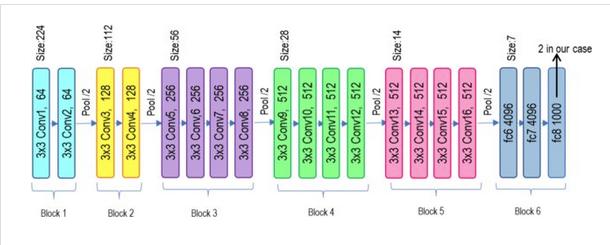

In [2]:
### first we need to build a generic block in order to repeat it.
### in the init function we will initialize all the parameters that are not constant
### we have to think what are the parameters for a usual CNN in order to initialize them
### as well as the numper of repetitions of each layer. Lets go


In [3]:
class Block(Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters= filters
        self.kernel_size=kernel_size
        self.repetitions= repetitions
        
        ## define the repeated layers of the CNN
        
        for repetition in range(self.repetitions):
            vars(self)[f'conv2D_{repetition}']= Conv2D(self.filters, self.kernel_size,
                                                      padding="same", activation="relu")
        ##define the max_pool layer
        
        self.max_pool= MaxPooling2D(pool_size= pool_size, strides=strides)
        
    ##Lets activate
    
    def call(self, inputs):
        ##get the zeroth conv_layer for the inputs
        
        conv2D_0 = vars(self)['conv2D_0']
        x= conv2D_0(inputs)
        
        ##for the remaining layers do the repetitions
        for repetition in range(1, self.repetitions):
            conv2D_repetition = vars(self)[f'conv2D_{repetition}']
            x=conv2D_repetition(x)
        x= self.max_pool(x)
        
        return x
            

In [4]:
class VGG19(Model):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()
        
        self.block_1 = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_2= Block(filters=128, kernel_size=3, repetitions=2)
        self.block_3 = Block(filters=256, kernel_size=3, repetitions=4)
        self.block_4 = Block(filters=512, kernel_size=3, repetitions=4)
        self.block_5= Block(filters=512, kernel_size=3, repetitions=4)
        
        self.flatten = Flatten()
        self.fc_1= Dense(4096, activation="relu") ##4096 = 7 * 512 +512(bias)
        self.fc_2= Dense(4096, activation="relu") ##4096 = 7 * 512 +512(bias)
        self.classifier= Dense(num_classes, activation="sigmoid")
        
    def call(self, inputs):
        x= self.block_1(inputs)
        x= self.block_2(x)
        x= self.block_3(x)
        x= self.block_4(x)
        x= self.block_5(x)
        x= self.flatten(x)
        x= self.fc_1(x)
        x= self.fc_2(x)
        x= self.classifier(x)
        return x
    
    ## this is just for checking
    
    def model(self):
        x = tf.keras.layers.Input(shape=(224, 224, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [5]:
model = VGG19(2)
model=model.model()
model.summary()
##all set

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block (Block)               (None, 112, 112, 64)      0         
                                                                 
 block_1 (Block)             (None, 56, 56, 128)       0         
                                                                 
 block_2 (Block)             (None, 28, 28, 256)       0         
                                                                 
 block_3 (Block)             (None, 14, 14, 512)       0         
                                                                 
 block_4 (Block)             (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0     